# SMS Classification

In this notebook, comparative analysis will be conduct by applying two diffrent approches,
one using TF-IDF with two traditional classifiers and another approache with fine-tune BERT for SMS classfication.
 
The required text preprocessing steps for TF-IDF are diffrenat than which are requierd using Bert for classification. TF-IDF is term frequency technique; Therefore, it need extra preproccessing steps. Accordingly, I will start with Bert first. 









In [ ]:
!nvidia-smi

Mon Jun 20 07:41:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. BERT




Fine-tuning Bert Approache 

- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build SMS Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict spam/ham on raw text



## Setup

[the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.4 MB 33.9 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 62.2 MB/s 
     |████████████████████████████████| 6.6 MB 49.0 MB/s 


In [ ]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 34.5 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.11.0+cu113
transformers: 4.20.0



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch


import numpy as np
import pandas as pd
import seaborn as sns
import re
import seaborn as sns
import time
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             f1_score, make_scorer, roc_auc_score)
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

load the SMS dataset.

In [ ]:
#Download data 
!mkdir -p data
!gsutil -m cp -r gs://novoic-ml-challenge-text-data/* ./data

Copying gs://novoic-ml-challenge-text-data/LICENSE...
Copying gs://novoic-ml-challenge-text-data/data.txt...
Copying gs://novoic-ml-challenge-text-data/README.md...
/ [3/3 files][468.7 KiB/468.7 KiB] 100% Done                                    
Operation completed over 3 objects/468.7 KiB.                                    


In [ ]:
# Load data and name columns
df = pd.read_csv("data/data.txt", sep="\t", names=['label','text'])

# Display 5 random samples
df.sample(5)

,label,text
3245,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
944,ham,And also I've sorta blown him off a couple tim...
1044,ham,Mmm thats better now i got a roast down me! i...
2484,ham,Mm have some kanji dont eat anything heavy ok
812,ham,So there's a ring that comes with the guys cos...


In [ ]:
df.shape

(5572, 2)

We have 5572 SMS texts. here will check for missing values:

In [ ]:
df.isnull().sum()

label    0
text     0
dtype: int64

no missing values in the score and review texts! checking class imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


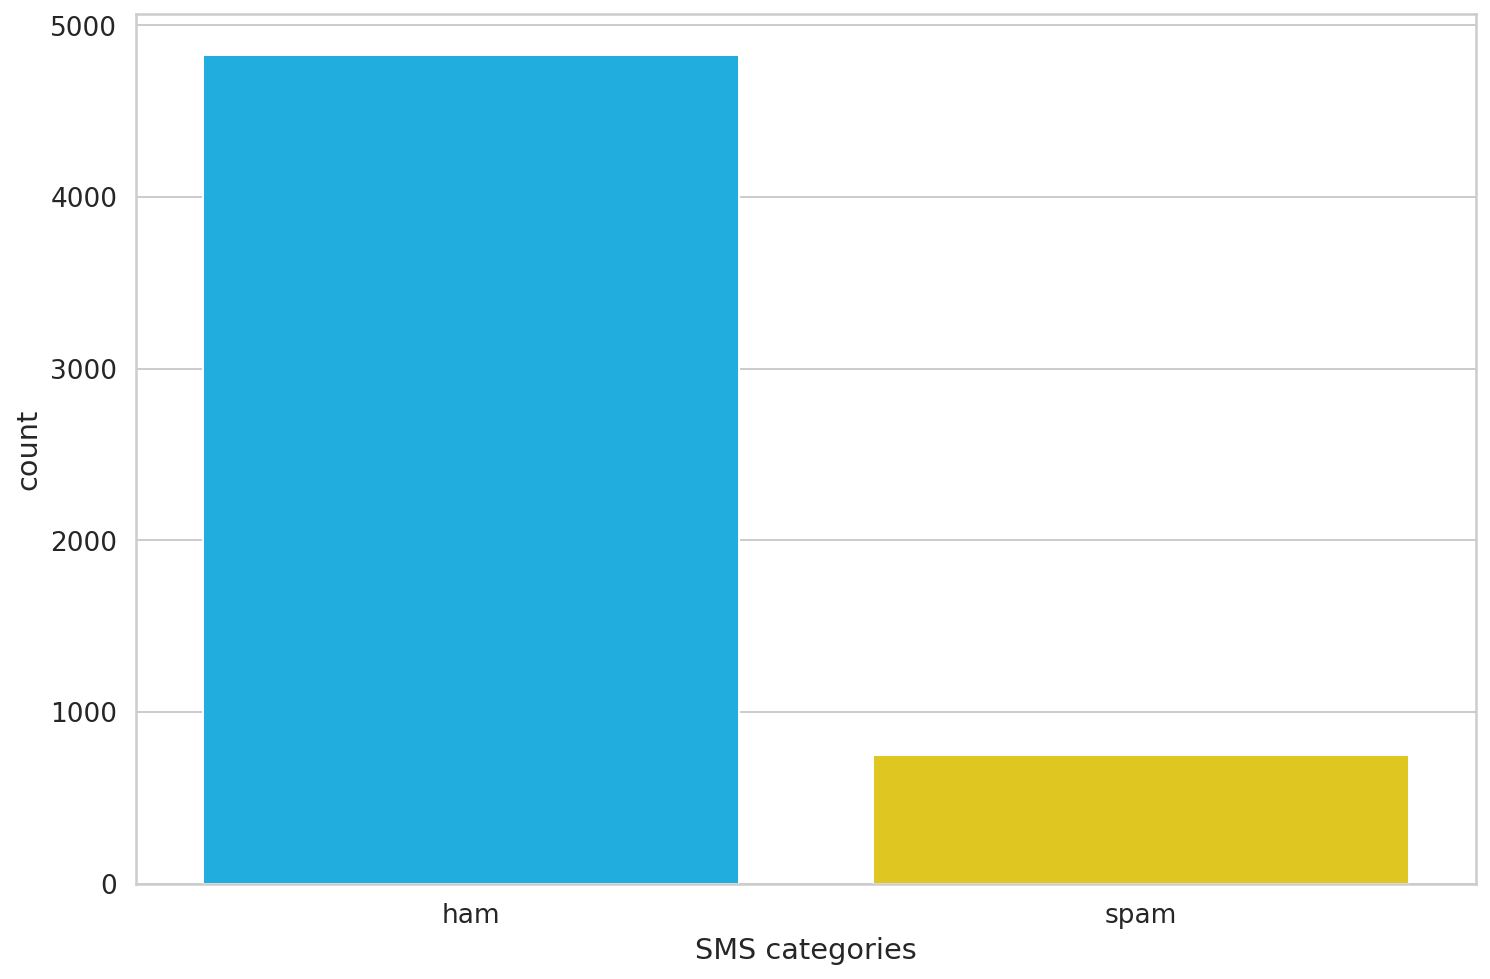

In [ ]:
sns.countplot(df.label)
plt.xlabel('SMS categories');

That's hugely imbalanced, will check the duplicates also

Check the importance Presence of digitis 

In [ ]:
def text_digit(x):
    return len(re.findall(r'\d+', x))
 # added to dataframe   
df['presence_of_digit'] = df['text'].map(text_digit)
df.head()

,label,text,presence_of_digit
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,6
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


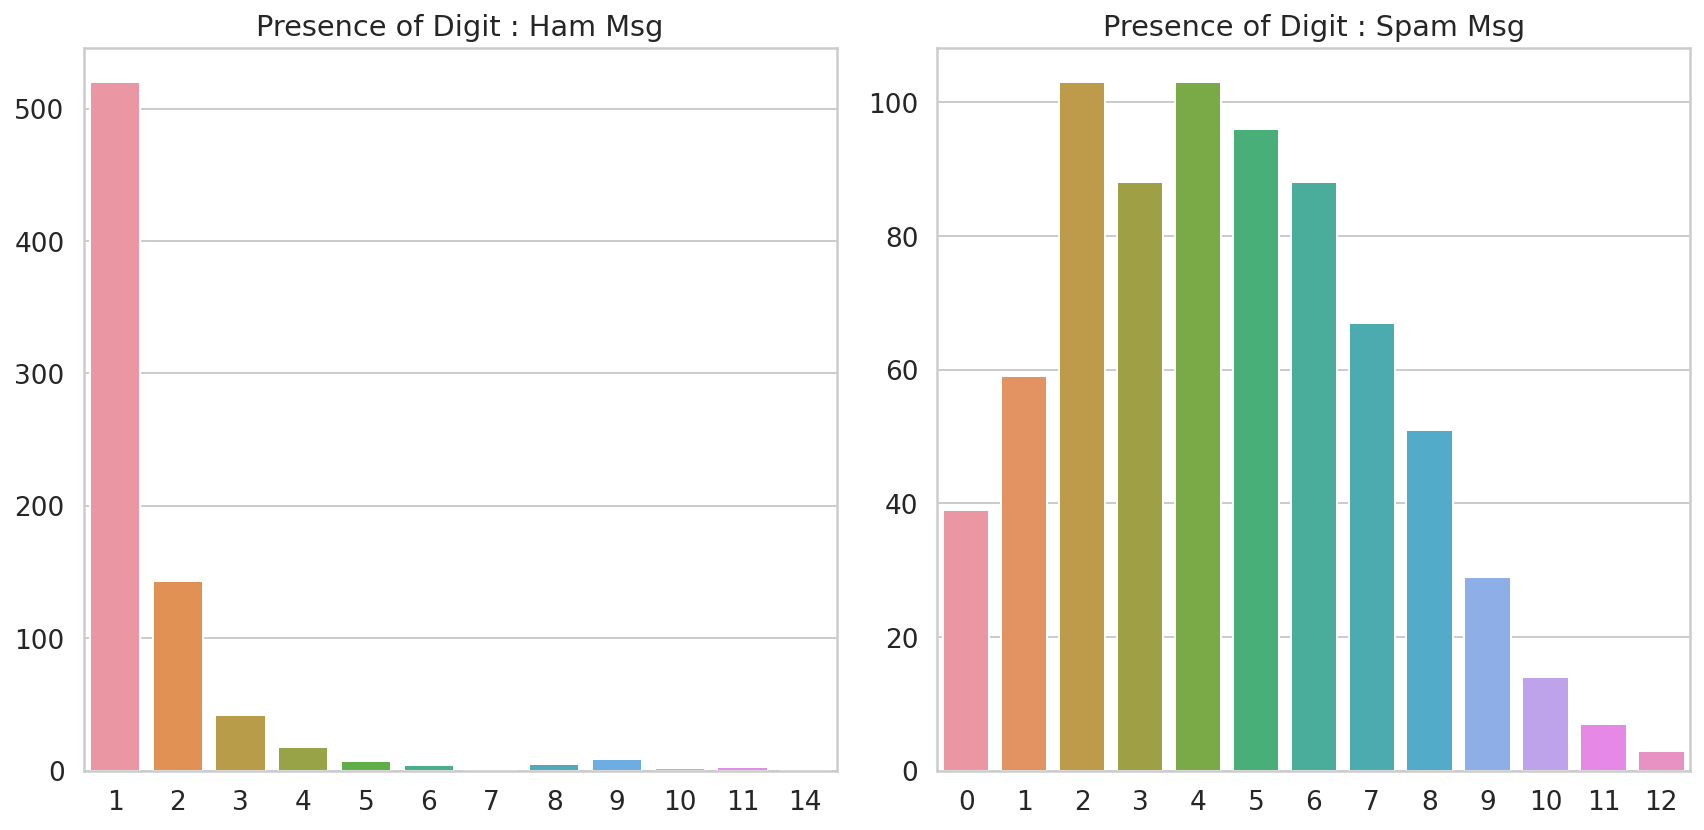

In [ ]:
plt.figure(figsize=(18, 6))


ax1 = plt.subplot(131)
ax1.set_title('Presence of Digit : Ham Msg')
y = list(df[df['label']=="ham"]['presence_of_digit'].value_counts().values[1:])
x = list(df[df['label']=="ham"]['presence_of_digit'].value_counts().keys()[1:])
sns.barplot(x=x, y=y, ax=ax1)

ax2 = plt.subplot(132)
ax2.set_title('Presence of Digit : Spam Msg')
y = list(df[df['label']=="spam"]['presence_of_digit'].value_counts().values)
x = list(df[df['label']=="spam"]['presence_of_digit'].value_counts().keys())
sns.barplot(x=x, y=y, ax=ax2)

plt.tight_layout()
plt.show()

for Ham messages, numeric apperence in messages is wither None or atleaset 1. There are very few cases where we see two or more numeric words present in Ham messages.

On the other hand, Spam messages contains two or more than 2 numerical words in messages which is more compared to that of Ham messages.

In [ ]:
df.drop('presence_of_digit', inplace=True, axis=1)

checking duplicates

In [ ]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
duplicatetext = df[df.duplicated(["text"])]
print(len(duplicatetext))

403


In [ ]:
#removing duplicates
df.drop_duplicates(subset=["text"], keep='last', inplace=True)

In [ ]:
df.describe()

,label,text
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [ ]:
#Labels conversion, with 0 for ham, 1 for spam
df["label"] = df["label"].apply(lambda x:1 if 'spam' in str(x) else 0)

## Data Augumentation
The SMS dataset is imbalanced dataset and this a problem where data belonging to one class (ham) is significantly higher than that belonging to other class(spam). 
Most ML/DL classification algorithms aren’t equipped to handle imbalanced classes and tend to get biased towards majority classes. There are multiple approaches to address data imbalance, here I will apply data augumentation to generate new spam SMS texts with the same meaning of the orignal spam texts that are already in the dataset.

In [ ]:
# we will split the data before augumentation to keep the test set and validation set without augumentation.
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=42, test_size=0.33)

In [ ]:
print(len(df_train))
print(len(df_test))

3463
1706


In [ ]:
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [ ]:
print(len(df_val))
print(len(df_val))

853
853


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
import nlpaug.augmenter.word.context_word_embs as aug

augmenter = aug.ContextualWordEmbsAug(model_path= PRE_TRAINED_MODEL_NAME, action="insert")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
sample_text = df_train.text.values
print(sample_text[0])

Well I wasn't available as I washob nobbing with last night so they had to ask Nickey Platt instead of me!;


In [ ]:
for i in range(3):
    print(augmenter.augment(sample_text[0]))

well sorry i wasn't available as i was washob nobbing with last night though so they still had not to really ask sir nickey platt but instead part of me! ;
well and i wasn'at t available as i washob into nobbing and with last night so they all had to quietly ask away nickey from platt instead of saying me! ;
no well i wasn't actually available as i liked washob nobbing with mom last saturday night so they had reason to just ask nickey the platt instead of picking me! ;


In [ ]:
#explore the number of spam texts to know the size of text that will be generated to make the dataset balanced
df_train.label.value_counts()

0    3030
1     433
Name: label, dtype: int64

In [ ]:
from sklearn.utils import shuffle
def augmentMyData(df, augmenter, repetitions=1, samples=200):
    augmented_texts = []
    # select only the minority class samples
    spam_df = df[df['label'] == 1].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df['text'].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        'label': 1,
        'text': augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df

In [ ]:
aug_df = augmentMyData(df_train, augmenter, samples=1300)

100%|██████████| 1300/1300 [49:27<00:00,  2.28s/it]


In [ ]:
aug_df['label'].value_counts()

0    3030
1    1733
Name: label, dtype: int64

In [ ]:
print("Original: ", df_train.shape)
print("Augmented: ", aug_df.shape)

Original:  (3463, 2)
Augmented:  (4763, 2)


In [ ]:
aug_df.to_csv("/content/drive/MyDrive/Mozn/Augmented_training.csv", index=False, encoding="utf-8")

In [ ]:
df_train.to_csv("/content/drive/MyDrive/Mozn/training_sms.csv", index=False, encoding="utf-8")

In [ ]:
df_test.to_csv("/content/drive/MyDrive/Mozn/testing_sms.csv", index=False, encoding="utf-8")

In [ ]:
df_val.to_csv("/content/drive/MyDrive/Mozn/val_sms.csv", index=False, encoding="utf-8")

In [ ]:
aug_df = pd.read_csv("/content/drive/MyDrive/Mozn/Augmented_training.csv", encoding="utf-8")
df_train = pd.read_csv("/content/drive/MyDrive/Mozn/training_sms.csv",  encoding="utf-8")
df_test = pd.read_csv("/content/drive/MyDrive/Mozn/testing_sms.csv", encoding="utf-8")
df_val = pd.read_csv("/content/drive/MyDrive/Mozn/val_sms.csv", encoding="utf-8")

## Data Preprocessing


- Removing double spaces between words.
- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*



Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True )

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### preprocessing



In [ ]:
import re
def text_preprocessing(text):

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

### Choosing Sequence Length

BERT works with fixed-length sequences. I will use a simple strategy to choose the max length. The token length of each sms will be store:

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(text_preprocessing(txt), truncation=True , max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


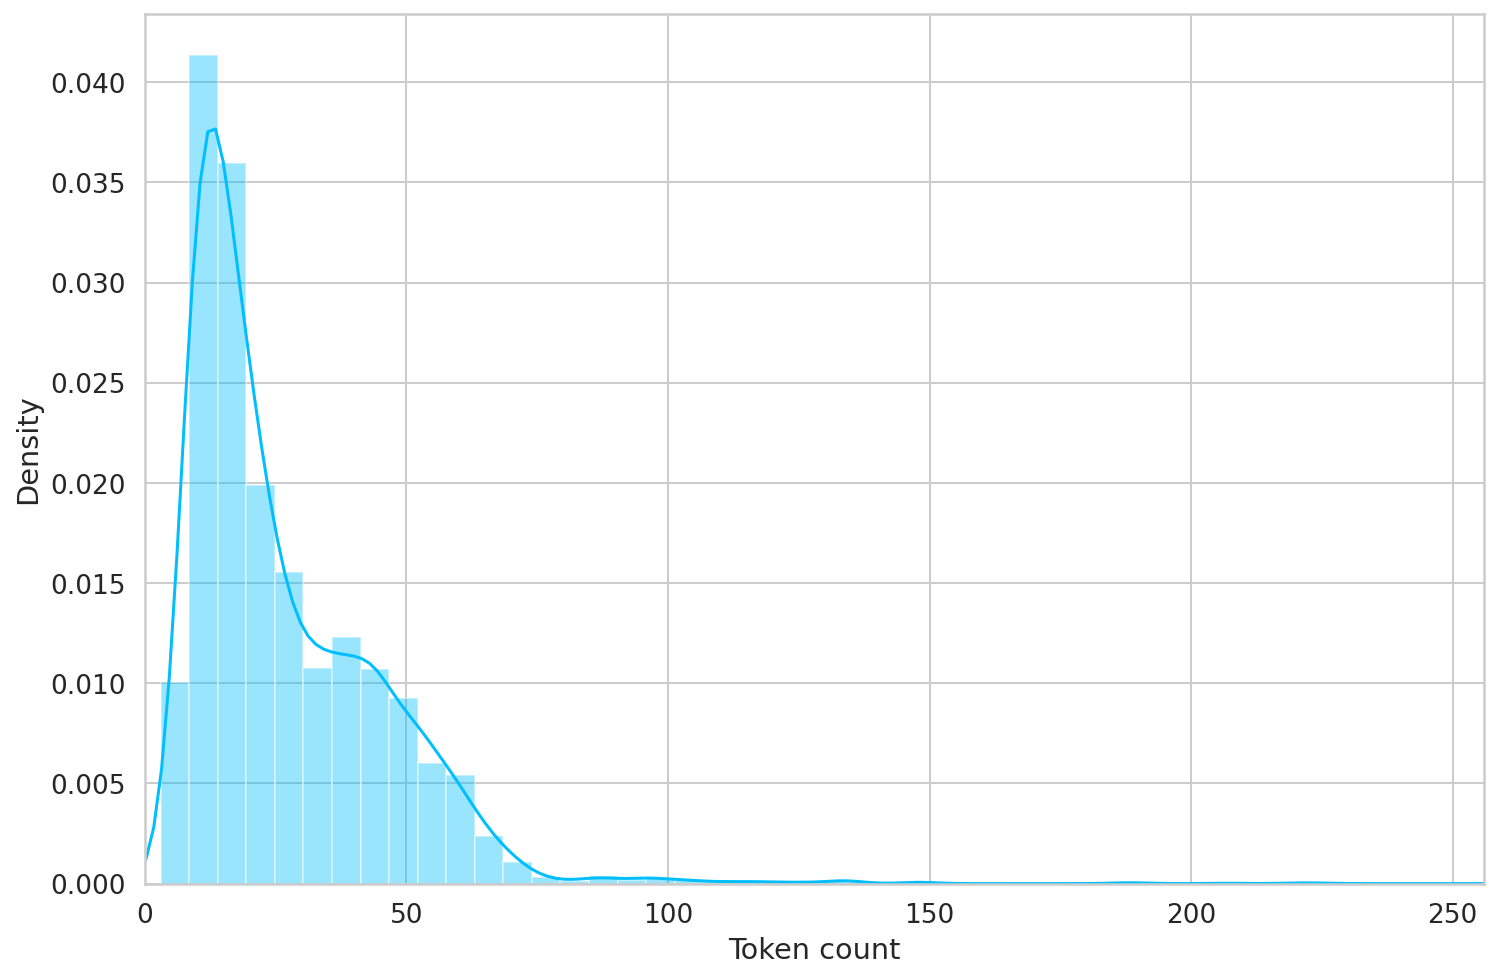

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the SMS text seem to contain less than 170 tokens, I will choose the maximum length of 175 be on the safe side.

### Loading Data

choose a maximum length of 175.

In [ ]:
MAX_LEN = 175

Create a PyTorch dataset.

In [ ]:
class SMSDataset(Dataset):

  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text_preprocessing(sentence),
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      padding='max_length',
      truncation=True,
      

    )

    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SMSDataset(
    sentences=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(aug_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
aug_df.text.to_numpy()

array(['ringtone message club : gr8 new me polys direct to mail your active mobile contacts every week!',
       'Omg if its not one thing its another. My cat has worms :/ when does this bad day end?',
       'Cos i want it to be your thing', ...,
       'Win a £1000 cash prize or a prize worth £5000',
       'free entry made into our own £250 million weekly comp just send the word winner win to my 80086 live now. 18 a t & r c on www. txttowin. dot co. uk',
       'Edison has rightly said, "A fool can ask more questions than a wise man can answer" Now you know why all of us are speechless during ViVa.. GM,GN,GE,GNT:-)'],
      dtype=object)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sentence_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 175])
torch.Size([16, 175])
torch.Size([16])


## SMS Classification with BERT and Hugging Face

building the classifier on top of Bert Model.load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SMSClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SMSClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.6)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. I used a dropout layer for some regularization and a fully-connected layer for the output. Note that returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

create an instance and move it to the GPU:

In [ ]:
class_names = ['ham', 'spam']
model = SMSClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


moving the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 175])
torch.Size([16, 175])


To get the predicted probabilities from our trained model, the softmax function will be applied to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5650, 0.4350],
        [0.8036, 0.1964],
        [0.4499, 0.5501],
        [0.9341, 0.0659],
        [0.2420, 0.7580],
        [0.4015, 0.5985],
        [0.3029, 0.6971],
        [0.4921, 0.5079],
        [0.3867, 0.6133],
        [0.5330, 0.4670],
        [0.8314, 0.1686],
        [0.5739, 0.4261],
        [0.6999, 0.3001],
        [0.5566, 0.4434],
        [0.8266, 0.1734],
        [0.3843, 0.6157]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
#Compute class weights for the labels in the dataset and then pass these weights to the loss function so that it takes care of the class imbalance. In PyTorch it can be done as shown below:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(aug_df.label.values), y= aug_df.label.values)

print("Class Weights:",class_weights)

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
    


Class Weights: [0.7859736  1.37420658]


In [ ]:
aug_df.label.values

array([1, 0, 0, ..., 1, 1, 0])

In [ ]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

tuning with hyperparameters, The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

As shown previously, I choose 16 for the Batch size, 2e-5 for learning rate, and 2 for the epochs number.


a helper function for training our model for one epoch:

In [ ]:
def train_epoch( model, data_loader, loss_fn, optimizer,  device,  scheduler,  n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. Avoiding exploding gradients are done by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).



In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, I write the training loop. also the training history will be stored:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 2)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(aug_df))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model( model, val_data_loader, loss_fn, device,  len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Mozn/3best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
--
Train loss 0.09603651999423653 accuracy 0.9743858912450136
Val   loss 0.07514330153504421 accuracy 0.9894490035169987

Epoch 2/2
--
Train loss 0.005541917176473996 accuracy 0.9985303380222549
Val   loss 0.09453427919989163 accuracy 0.9894490035169987

CPU times: user 3min 40s, sys: 1min 28s, total: 5min 8s
Wall time: 5min 14s


Note that the state of the best model stored, that is indicated by the highest validation accuracy.

The training accuracy starts to approach 100% after 2 epochs, but this will be good enough for SMS classfication.

In order to use the SMS classification model, uncomment the next cell to download my pre-trained model:

In [ ]:

# model = SMSClassifier(len(class_names))
# model.load_state_dict(torch.load('/content/drive/MyDrive/Mozn/3best_model_state.bin'))
# model = model.to(device)

## Evaluation
Calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device,len(df_test))

test_acc.item()

0.9964830011723329

The accuracy is slightly less lower on the test set. The model seems to generalize well.

Defining a helper function to get the predictions from SMS model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  SMS_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sentence_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      SMS_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return SMS_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the SMS and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       755
        spam       0.99      0.98      0.98        98

    accuracy                           1.00       853
   macro avg       0.99      0.99      0.99       853
weighted avg       1.00      1.00      1.00       853





The confusion matrix:

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');



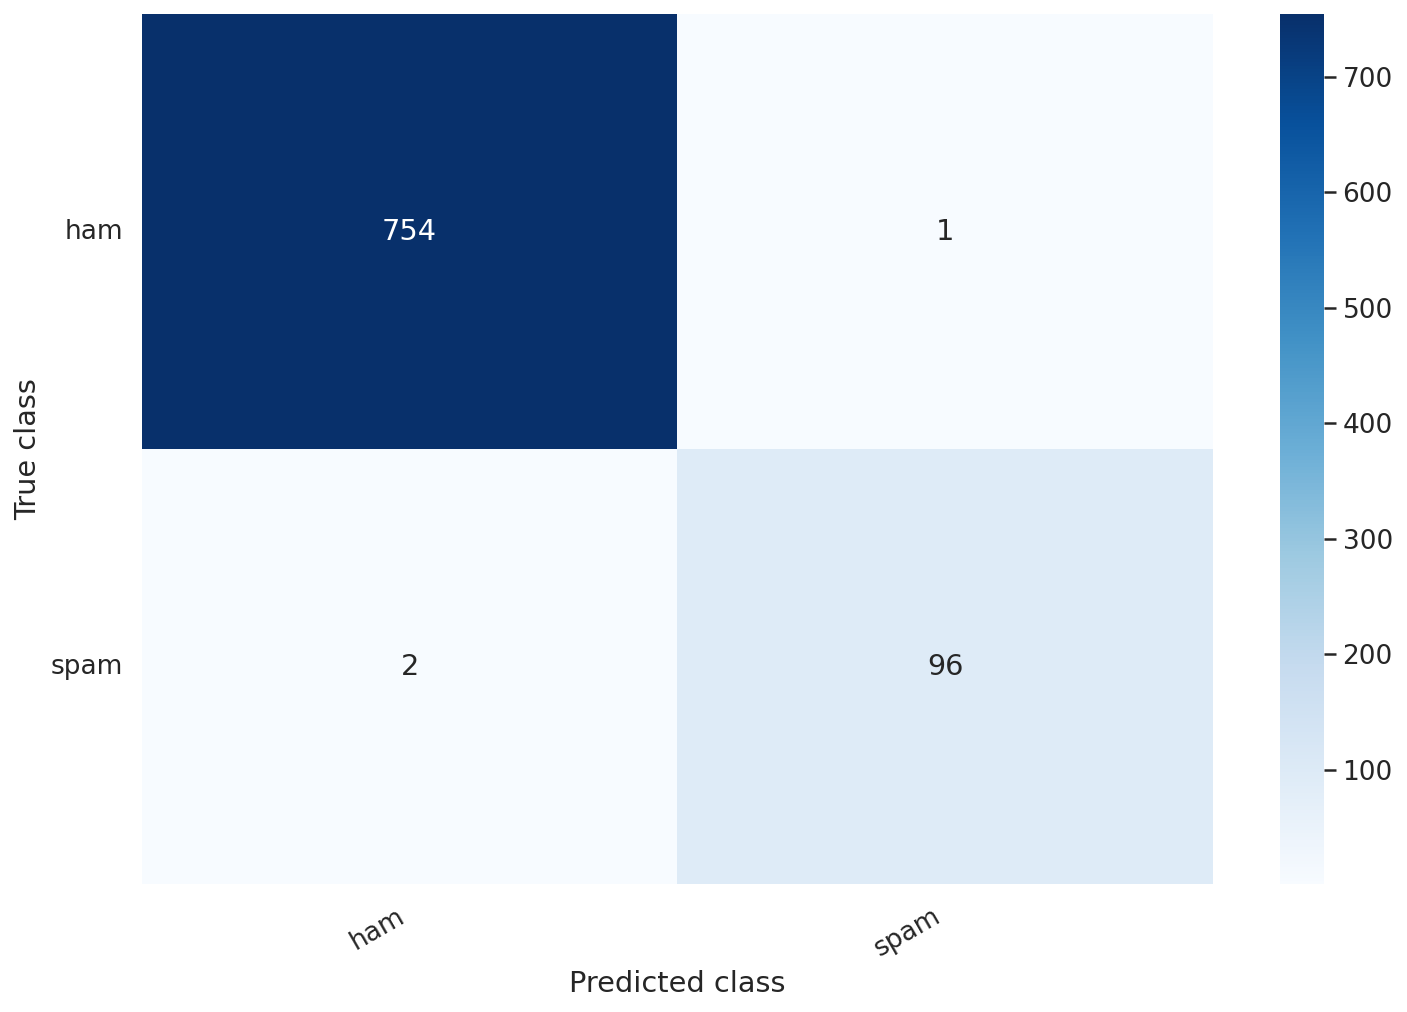

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that fintuning Bert model is State of the art. 

That's a good overview of the performance of the model.

### Predicting on Raw Text

Let's use our model to predict the SMS class of some raw text:

In [ ]:
review_text = ":("

First, the tokenizer will be used to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  padding='max_length',
  truncation=True,
)


Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'SMS text: {review_text}')
print(f'Class  : {class_names[prediction]}')

SMS text: :(
Class  : ham


## TF-IDF + SGD and Naive Bayes

Term frequency — Inverse document frequency (TFIDF) is based on the Bag of Words (BoW) model, which contains insights about the less relevant and more relevant words in a document. The importance of a word in the text is of great significance in information retrieval.
Therofore, the text is represented disregarding grammar and word meaning. Therefore, the following steps will be applied:
remove stop words, and punctuations that don't contribute much to the 

*   Text cleaning ( removing punctuations, and extra white space)
*   removing stop words.


 According to the importance of digit as features as shown in data exploration, the numbers will be kept in text. There are also stemming and lemtization techniques that usually implemented, both  of these techniques are trying to reduce the words to its most basic form. However, I choose not to apply it, since it is not usefull spam and ham classfication problem.

#### Text Preprocessing

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words("english")

def clean_text(x):
    x = re.sub(r"[!\"#$%()*+,.-/:;<=>?@^_`{|}~]", " ", x)#remove punctioation 
    x = re.sub(r"http\S+", "",x)#remove url 
    x = re.sub(r"e - mail", " ", x)#remove email
    x = re.sub(r"\s{2,}", " ", x)
    return x
  
def remove_stop(text):
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word.lower() for word in text.split()
                  if word.lower() not in stopwords])
    return s

def text_preprocessing(sent):
    text = clean_text(sent)
    text = remove_stop(text)
    return text 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Apply text preproccessing on data 
aug_df["text_pre"] = aug_df["text"].map(lambda x: text_preprocessing(x))
df_test["text_pre"] = df_test["text"].map(lambda x: text_preprocessing(x))
df_val["text_pre"] = df_val["text"].map(lambda x: text_preprocessing(x))


In [ ]:
# checking text length after preproccesing
aug_df.loc[aug_df["text_pre"].str.len() ==0]

,label,text,text_pre
2358,0,:),
2453,0,Where @,
2857,0,Can a not?,
2926,0,:( but your not here....,
4525,0,What you doing?how are you?,


In [ ]:
df_val.loc[df_val["text_pre"].str.len() ==0]

,label,text,text_pre


In [ ]:
df_test.loc[df_test["text_pre"].str.len() ==0]

,label,text,text_pre


In [ ]:
#removing empty text rows 
aug_df.drop(aug_df.loc[aug_df["text_pre"].str.len() ==0].index, inplace=True)

#### Hyper-parameter Tuning SGD and Naive Bayes classifiers

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, make_scorer, roc_curve, 
                             auc, average_precision_score, roc_auc_score)
import time
import operator
from operator import itemgetter
#pipeline parameters
parameters = \
        [ \
            {   
                
                'clf': [MultinomialNB()],
                'tfidf__ngram_range': ((1, 1), (1, 2)),
                 'tfidf__max_features': (None, 500, 1000),
              
                 'tfidf__use_idf': [True],
                'clf__alpha': [0.001, 0.1, 0.5, 0.3, 0.8, 1, 10, 100]
              
                 
            },

            {
                'clf': [SGDClassifier()],
                'tfidf__ngram_range': ((1, 1), (1, 2)),
                'tfidf__max_features': (None, 500, 1000),
                'tfidf__use_idf': [True],
                'clf__alpha': (0.00001, 0.000001),
                'clf__class_weight':['balanced']
  
                 
             
            
            },

           
         
        ]

    #evaluating multiple classifiers
    #based on pipeline parameters
    #-------------------------------
result=[]
f1_scorer = make_scorer(f1_score)
start = time.time()
for params in parameters:
   #classifier
        clf = params['clf'][0]

        #getting arguments by
        #popping out classifier
        params.pop('clf')

        #pipeline
        steps = [("tfidf", TfidfVectorizer()),('clf',clf)]
        
        #cross validation using
        #Grid Search
        grid = GridSearchCV(Pipeline(steps), param_grid=params, cv=5, scoring=f1_scorer)
        grid.fit(aug_df["text_pre"], aug_df["label"])

        #storing result
        result.append\
        (
            {
                'grid': grid,
                'classifier': grid.best_estimator_,
                'best score': grid.best_score_,
                'best params': grid.best_params_,
                'cv': grid.cv
            }
        )
end = time.time()
#sorting result by best score
result = sorted(result, key=operator.itemgetter('best score'),reverse=True)
print("The total time is : "+str((end - start)/60)+" minutes ")

The total time is : 0.7387247721354167 minutes 


In [ ]:
result

[{'best params': {'clf__alpha': 1e-05,
   'clf__class_weight': 'balanced',
   'tfidf__max_features': None,
   'tfidf__ngram_range': (1, 1),
   'tfidf__use_idf': True},
  'best score': 0.9877297916823657,
  'classifier': Pipeline(steps=[('tfidf', TfidfVectorizer()),
                  ('clf', SGDClassifier(alpha=1e-05, class_weight='balanced'))]),
  'cv': 5,
  'grid': GridSearchCV(cv=5,
               estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                         ('clf', SGDClassifier())]),
               param_grid={'clf__alpha': (1e-05, 1e-06),
                           'clf__class_weight': ['balanced'],
                           'tfidf__max_features': (None, 500, 1000),
                           'tfidf__ngram_range': ((1, 1), (1, 2)),
                           'tfidf__use_idf': [True]},
               scoring=make_scorer(f1_score))},
 {'best params': {'clf__alpha': 0.5,
   'tfidf__max_features': None,
   'tfidf__ngram_range': (1, 2),
   'tfidf__us

As shwon above the best results are:

*   Naive Bayes : Bi-gram Tf-IDF Vectorizer
*   SGD : Uni-gram Tf-IDF Vectorizer

According the above mentioned model will be considerd with the best alpha founded in grid search results.
 

#### SGD:  Unigram TF-IDF  

In [ ]:
Uni_tf_idf = TfidfVectorizer(ngram_range=(1, 1))
X_train_Uni_tfidf = Uni_tf_idf.fit_transform(aug_df["text_pre"])
X_val_Uni_tfidf = Uni_tf_idf.transform(df_val["text_pre"])
X_test_Uni_tfidf = Uni_tf_idf.transform(df_test["text_pre"])

In [ ]:
def SGD_model(train_text, Y_train, val_text, Y_val ):
    SGD_clf      = SGDClassifier(alpha=1e-05, class_weight='balanced')
    SGD_clf.fit(train_text, Y_train)
    pred        = SGD_clf.predict(val_text)
    auc_score   = roc_auc_score(Y_val, pred)
    f1_score_ =  f1_score(pred, Y_val)
    return SGD_clf,auc_score, f1_score_

In [ ]:
SGDmodel ,cv_auc, f1  = SGD_model(X_train_Uni_tfidf, aug_df["label"], X_val_Uni_tfidf, df_val["label"])
print ("Validate F1 score", f1)
print ("Validate ROC AUC Score:", cv_auc)

Validate F1 score 0.9053497942386831
Validate ROC AUC Score: 0.943295732322666


##### SGD Evaluation

In [ ]:
test_SGD = SGDmodel.predict(X_test_Uni_tfidf)
print(classification_report(test_SGD,df_test["label"], target_names=class_names))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       755
        spam       0.94      0.94      0.94        98

    accuracy                           0.99       853
   macro avg       0.97      0.97      0.97       853
weighted avg       0.99      0.99      0.99       853



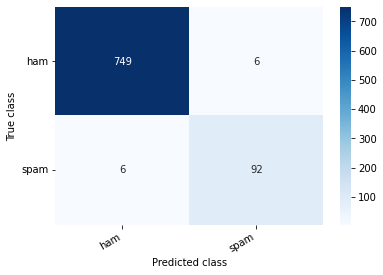

In [ ]:
SGD_cm = confusion_matrix(df_test["label"], test_SGD)
SGD_df_cm = pd.DataFrame(SGD_cm, index=class_names, columns=class_names)
show_confusion_matrix(SGD_df_cm)

In [ ]:
print("Test ROC AUC Score:",roc_auc_score(test_SGD,df_test["label"]))

Test ROC AUC Score: 0.9654142451682661


Exploring Features importance 

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

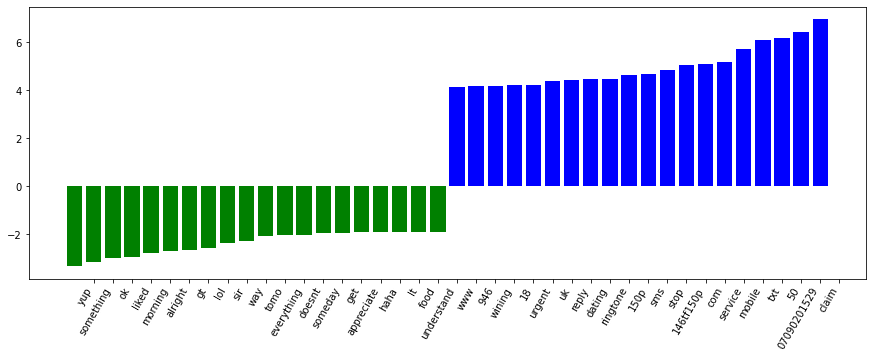

In [ ]:
plot_coefficients(SGDmodel, Uni_tf_idf.get_feature_names_out())

#### Naive Bayes: Bigram TF-IDF

In [ ]:
Bi_tf_idf = TfidfVectorizer(ngram_range=(1, 2))
Bi_X_train_tfidf = Bi_tf_idf.fit_transform(aug_df["text_pre"])
Bi_X_val_tfidf = Bi_tf_idf.transform(df_val["text_pre"])
Bi_X_test_tfidf = Bi_tf_idf.transform(df_test["text_pre"])

In [ ]:
def naive_bayes_model(train_text, Y_train, val_text, Y_val):
    nb_clf      = MultinomialNB(alpha=0.5)
    nb_clf.fit(train_text, Y_train)
    pred        = nb_clf.predict(val_text)
    auc_score   = roc_auc_score(Y_val, pred)
    f1_score_ =  f1_score(pred, Y_val)
    return nb_clf,auc_score, f1_score_

In [ ]:
NBmodel ,cv_auc_NB, f1_NB  = naive_bayes_model(Bi_X_train_tfidf, aug_df["label"], Bi_X_val_tfidf, df_val["label"])
print ("Validate F1 score", f1_NB)
print ("Validate ROC AUC Score:", cv_auc_NB)

Validate F1 score 0.9230769230769231
Validate ROC AUC Score: 0.9596891749456168


##### NB Evaluation

In [ ]:
test_NB = NBmodel.predict(Bi_X_test_tfidf)
print(classification_report(test_NB,df_test["label"], target_names=class_names))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       747
        spam       0.96      0.89      0.92       106

    accuracy                           0.98       853
   macro avg       0.97      0.94      0.96       853
weighted avg       0.98      0.98      0.98       853



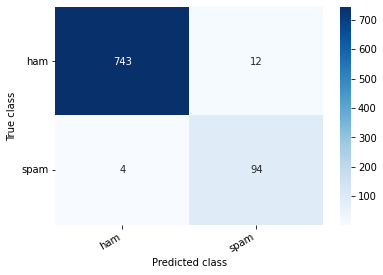

In [ ]:
NB_cm = confusion_matrix(df_test["label"], test_NB)
NB_df_cm = pd.DataFrame(NB_cm, index=class_names, columns=class_names)
show_confusion_matrix(NB_df_cm)

In [ ]:
print("Test ROC AUC Score:",roc_auc_score(test_NB ,df_test["label"]))

Test ROC AUC Score: 0.9407188502437424


Feature importance extraction

In [ ]:
neg_class_prob_sorted = NBmodel.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = NBmodel.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(Bi_tf_idf.get_feature_names_out(), neg_class_prob_sorted[:20]))
print(np.take(Bi_tf_idf.get_feature_names_out(), pos_class_prob_sorted[:20]))

['ok' 'gt' 'lt' 'get' 'come' 'lt gt' 'good' 'got' 'know' 'like' 'll'
 'going' 'lor' 'time' 'go' 'day' 'da' 'home' 'love' 'still']
['call' 'free' 'mobile' 'stop' 'text' 'txt' 'ur' 'prize' 'reply' 'claim'
 'please' 'new' 'www' 'cash' 'nokia' 'send' '150p' 'com' 'service' 'uk']


#### Saving Models
 

In [ ]:
# loading library pickle
import pickle
# to save model create an iterator object with write permission - model.pkl
with open('/content/drive/MyDrive/Mozn/SGDmodel_pkl', 'wb') as files:
    pickle.dump(SGDmodel, files)
    files.close()
with open('/content/drive/MyDrive/Mozn/NBmodel_pkl', 'wb') as files:
    pickle.dump(NBmodel, files)
    files.close()



## Conclusion
In the first approache I built a custom classifier using the Hugging Face library By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT and trained it on SMS dataset. 
Both Naive Bayes and SGD classifier from simple Machine Learning model perform well. However, the performance evaluation on test set showed that fine-tuning Bert can achieve state-of-the-art performance.  